In [293]:
# Импорт библиотек и настройка
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

print("Библиотеки успешно загружены")

Библиотеки успешно загружены


In [294]:
# Определение целевой функции и параметров
def f(x):
    """
    f(x₁, x₂) = 10x₁ - x₂ + exp(x₁ + 2x₂)
    """
    return 10 * x[0] - x[1] + math.exp(x[0] + 2 * x[1])

def grad_f(x):
    exp_term = math.exp(x[0] + 2 * x[1])
    return np.array([10 + exp_term, -1 + 2 * exp_term])


SEARCH_BOUNDS = {
    'x1_min': -1000,   # Ограничение слева
    'x1_max': 1000,    # Ограничение справа  
    'x2_min': -1000,   # Ограничение снизу
    'x2_max': 1000    # Ограничение сверху
}

# Параметры задачи
x0 = np.array([-999.0, 1.0])  # Начальное приближение (из условия)
epsilon = 0.0003           # Точность (из условия)

print("="*80)
print("ПАРАМЕТРЫ ЗАДАЧИ")
print("="*80)
print("Целевая функция: f(x₁, x₂) = 10x₁ - x₂ + exp(x₁ + 2x₂)")
print(f"\nОграничения области поиска:")
print(f"  x₁ ∈ [{SEARCH_BOUNDS['x1_min']}, {SEARCH_BOUNDS['x1_max']}]")
print(f"  x₂ ∈ [{SEARCH_BOUNDS['x2_min']}, {SEARCH_BOUNDS['x2_max']}]")
print(f"\nНачальная точка: x0 = ({x0[0]}, {x0[1]})")
print(f"Точность: ε = {epsilon}")
print("\nМетоды оптимизации:")
print("1. Метод наискорейшего спуска ")
print("2. Метод Хука-Дживса ")
print("="*80)

ПАРАМЕТРЫ ЗАДАЧИ
Целевая функция: f(x₁, x₂) = 10x₁ - x₂ + exp(x₁ + 2x₂)

Ограничения области поиска:
  x₁ ∈ [-1000, 1000]
  x₂ ∈ [-1000, 1000]

Начальная точка: x0 = (-999.0, 1.0)
Точность: ε = 0.0003

Методы оптимизации:
1. Метод наискорейшего спуска 
2. Метод Хука-Дживса 


In [295]:
# Вспомогательные функции
def golden_section_search(f, a, b, eps=1e-6, max_iter=100):
    """Поиск минимума методом золотого сечения"""
    phi = (math.sqrt(5) - 1) / 2
    
    for _ in range(max_iter):
        if abs(b - a) < eps:
            break
            
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
        
        if f(x1) < f(x2):
            b = x2
        else:
            a = x1
    
    return (a + b) / 2

def apply_bounds(point, bounds):
    """Применяет ограничения к точке"""
    point[0] = max(bounds['x1_min'], min(bounds['x1_max'], point[0]))
    point[1] = max(bounds['x2_min'], min(bounds['x2_max'], point[1]))
    return point

def is_in_bounds(point, bounds):
    """Проверяет, находится ли точка в пределах области"""
    return (bounds['x1_min'] <= point[0] <= bounds['x1_max'] and
            bounds['x2_min'] <= point[1] <= bounds['x2_max'])

print("Вспомогательные функции созданы")

Вспомогательные функции созданы


In [296]:
#Метод наискорейшего спуска
def steepest_descent_bounded(f, grad, x0, bounds, eps=0.0003, max_iter=1000, verbose=True):
    """
    Метод наискорейшего спуска с ограниченной областью поиска
    """
    x = x0.copy()
    trajectory = [x.copy()]
    f_calls = 0
    grad_calls = 0
    iterations = 0
    
    if verbose:
        print("\n" + "="*60)
        print("Метод наискорейшего спуска")
        print("="*60)
        print(f"Ограничения: x₁∈[{bounds['x1_min']},{bounds['x1_max']}], "
              f"x₂∈[{bounds['x2_min']},{bounds['x2_max']}]")
        print(f"Начальная точка: [{x[0]:.4f}, {x[1]:.4f}]")
        print(f"f(x0) = {f(x):.6f}")
        print(f"Критерий остановки: ||∇f|| < {eps}")
    
    for iteration in range(max_iter):
        # Вычисление градиента
        grad_val = grad(x)
        grad_calls += 1
        grad_norm = np.linalg.norm(grad_val)
        
        if verbose and iteration % 5 == 0:
            print(f"Итерация {iteration:3d}: x=[{x[0]:7.4f}, {x[1]:7.4f}], "
                  f"f(x)={f(x):10.6f}, ||∇f||={grad_norm:10.6f}")
        
        # критерий остановки
        if grad_norm < eps:
            if verbose:
                print(f"\n✓ Достигнута точность на итерации {iteration}")
                print(f"  ||∇f|| = {grad_norm:.6f} < ε = {eps}")
            break
        
        # Функция для одномерной оптимизации с учетом границ
        def phi(alpha):
            nonlocal f_calls
            f_calls += 1
            new_point = x - alpha * grad_val
            new_point = apply_bounds(new_point.copy(), bounds)
            return f(new_point)
        
        # Находим оптимальный шаг
        alpha_max = 1.0
        # Проверяем, не выходим ли за границы при максимальном шаге
        test_point = x - alpha_max * grad_val
        while not is_in_bounds(test_point, bounds):
            alpha_max *= 0.5
            if alpha_max < 1e-10:
                alpha_max = 0
                break
            test_point = x - alpha_max * grad_val
        
        if alpha_max > 0:
            alpha_opt = golden_section_search(phi, 0, min(alpha_max, 2.0), eps/10)
        else:
            alpha_opt = 0
        
        # Обновляем точку с учетом границ
        if alpha_opt > 0:
            x = x - alpha_opt * grad_val
            x = apply_bounds(x, bounds)
        
        trajectory.append(x.copy())
        iterations = iteration + 1
        
        #если достигнута граница
        if (abs(x[0] - bounds['x1_min']) < eps or 
            abs(x[0] - bounds['x1_max']) < eps):
            if verbose:
                print(f"\n✓ Достигнута граница области на итерации {iteration}")
                print(f"  x₁ = {x[0]:.6f} (граница: {bounds['x1_min']})")
            break
    
    if verbose:
        print(f"\n{'─'*50}")
        print("РЕЗУЛЬТАТЫ:")
        print(f"  Конечная точка: [{x[0]:.8f}, {x[1]:.8f}]")
        print(f"  f(x) = {f(x):.10f}")
        print(f"  Норма градиента: {np.linalg.norm(grad(x)):.10f}")
        print(f"  Итераций: {iterations}")
        print(f"  Вызовов f(x): {f_calls}")
        print(f"  Вызовов ∇f(x): {grad_calls}")
        print(f"  Всего вычислений: {f_calls + grad_calls}")
        print("="*60)
    
    return {
        'x_min': x,
        'trajectory': np.array(trajectory),
        'f_calls': f_calls,
        'grad_calls': grad_calls,
        'iterations': iterations,
        'f_value': f(x),
        'method': 'steepest_descent_bounded'
    }

In [297]:
#Метод Хука-Дживса
def hooke_jeeves_bounded(f, x0, bounds, step=0.5, step_reduction=0.5, 
                        eps=0.0003, max_iter=1000, verbose=True):
   
    n = len(x0)
    x = x0.copy()
    x_base = x0.copy()
    f_base = f(x_base)
    
    trajectory = [x.copy()]
    f_calls = 1
    iterations = 0
    
    if verbose:
        print("\n" + "="*60)
        print("Метод Хука-Дживса")
        print("="*60)
        print(f"Ограничения: x₁∈[{bounds['x1_min']},{bounds['x1_max']}], "
              f"x₂∈[{bounds['x2_min']},{bounds['x2_max']}]")
        print(f"Начальная точка: [{x[0]:.4f}, {x[1]:.4f}]")
        print(f"f(x0) = {f_base:.6f}")
        print(f"Начальный шаг: {step}")
        print(f"Критерий остановки: шаг < {eps}")
    
    # Применяем ограничения к начальной точке
    x = apply_bounds(x.copy(), bounds)
    x_base = x.copy()
    
    while step > eps and iterations < max_iter:
        if verbose and iterations % 10 == 0:
            print(f"Итерация {iterations:3d}: x=[{x[0]:7.4f}, {x[1]:7.4f}], "
                  f"f(x)={f(x):10.6f}, шаг={step:10.6f}")
        
        # поиск с учетом границ
        improved = False
        for i in range(n):
            original_value = x[i]
            
            # Пробуем положительное направление
            x_temp = x.copy()
            x_temp[i] = original_value + step
            x_temp = apply_bounds(x_temp, bounds)
            f_plus = f(x_temp)
            f_calls += 1
            
            # Пробуем отрицательное направление
            x_temp2 = x.copy()
            x_temp2[i] = original_value - step
            x_temp2 = apply_bounds(x_temp2, bounds)
            f_minus = f(x_temp2)
            f_calls += 1
            
            # Текущее значение
            f_current = f(x)
            f_calls += 1
            
            # Выбираем наилучшее направление
            if f_plus < f_current and f_plus <= f_minus:
                x[i] = original_value + step
                x = apply_bounds(x, bounds)
                f_current = f_plus
                improved = True
            elif f_minus < f_current:
                x[i] = original_value - step
                x = apply_bounds(x, bounds)
                f_current = f_minus
                improved = True
        
        # Если исследование дало улучшение
        if improved:
            # Поиск по образцу
            x_pattern = 2 * x - x_base
            x_pattern = apply_bounds(x_pattern, bounds)
            f_pattern = f(x_pattern)
            f_calls += 1
            
            if f_pattern < f(x):
                x_base = x.copy()
                x = x_pattern.copy()
                f_base = f_pattern
            else:
                x_base = x.copy()
                f_base = f(x)
        else:
            # Уменьшаем шаг
            step *= step_reduction
        
        trajectory.append(x.copy())
        iterations += 1
        
        # Критерий остановки по изменению функции
        if len(trajectory) > 2:
            f_prev = f(trajectory[-2])
            f_curr = f(x)
            if abs(f_curr - f_prev) < eps:
                if verbose:
                    print(f"\n✓ Малое изменение функции: |Δf|={abs(f_curr - f_prev):.6f}")
                break
        
        # Критерий остановки: достигнута граница и нет улучшений
        if (abs(x[0] - bounds['x1_min']) < eps or 
            abs(x[0] - bounds['x1_max']) < eps):
            if not improved:
                if verbose:
                    print(f"\n✓ Достигнута граница области без улучшений")
                    print(f"  x₁ = {x[0]:.6f} (граница: {bounds['x1_min']})")
                break
    
    if verbose:
        print(f"\n{'─'*50}")
        print("Результаты:")
        print(f"  Конечная точка: [{x[0]:.8f}, {x[1]:.8f}]")
        print(f"  f(x) = {f(x):.10f}")
        print(f"  Финальный шаг: {step:.10f}")
        print(f"  Итераций: {iterations}")
        print(f"  Вызовов f(x): {f_calls}")
        print(f"  Всего вычислений: {f_calls}")
        print("="*60)
    
    return {
        'x_min': x,
        'trajectory': np.array(trajectory),
        'f_calls': f_calls,
        'grad_calls': 0,
        'iterations': iterations,
        'f_value': f(x),
        'final_step': step,
        'method': 'hooke_jeeves_bounded'
    }

In [298]:
# Cell 6: Запуск методов оптимизации
print("\n" + "="*80)
print("Запуск методов")
print("="*80)
print("Ограничения:")
print(f"  x₁ ∈ [{SEARCH_BOUNDS['x1_min']}, {SEARCH_BOUNDS['x1_max']}]")
print(f"  x₂ ∈ [{SEARCH_BOUNDS['x2_min']}, {SEARCH_BOUNDS['x2_max']}]")
print(f"\nНачальная точка: x0 = [{x0[0]}, {x0[1]}]")
print(f"Точность: ε = {epsilon}")
print("="*80)

# Запускаем метод наискорейшего спуска
print("\n" + "="*80)
print("1. МЕТОД НАИСКОРЕЙШЕГО СПУСКА")
print("="*80)
result_sd = steepest_descent_bounded(f, grad_f, x0, SEARCH_BOUNDS, 
                                   eps=epsilon, verbose=True, max_iter=5000)

print("\n" + "="*80)
print("2. МЕТОД ХУКА-ДЖИВСА")
print("="*80)
result_hj = hooke_jeeves_bounded(f, x0, SEARCH_BOUNDS, step=0.5, 
                               step_reduction=0.5, eps=epsilon, 
                               verbose=True, max_iter=5000)

print("\n Оба метода завершены успешно с одинаковыми ограничениями!")


Запуск методов
Ограничения:
  x₁ ∈ [-1000, 1000]
  x₂ ∈ [-1000, 1000]

Начальная точка: x0 = [-999.0, 1.0]
Точность: ε = 0.0003

1. МЕТОД НАИСКОРЕЙШЕГО СПУСКА

Метод наискорейшего спуска
Ограничения: x₁∈[-1000,1000], x₂∈[-1000,1000]
Начальная точка: [-999.0000, 1.0000]
f(x0) = -9991.000000
Критерий остановки: ||∇f|| < 0.0003
Итерация   0: x=[-999.0000,  1.0000], f(x)=-9991.000000, ||∇f||= 10.049876
Итерация   5: x=[-999.9979,  1.0998], f(x)=-10001.079217, ||∇f||= 10.049876

✓ Достигнута граница области на итерации 7
  x₁ = -999.999724 (граница: -1000)

──────────────────────────────────────────────────
РЕЗУЛЬТАТЫ:
  Конечная точка: [-999.99972360, 1.09997236]
  f(x) = -10001.0972083119
  Норма градиента: 10.0498756211
  Итераций: 8
  Вызовов f(x): 124
  Вызовов ∇f(x): 8
  Всего вычислений: 132

2. МЕТОД ХУКА-ДЖИВСА

Метод Хука-Дживса
Ограничения: x₁∈[-1000,1000], x₂∈[-1000,1000]
Начальная точка: [-999.0000, 1.0000]
f(x0) = -9991.000000
Начальный шаг: 0.5
Критерий остановки: шаг < 0.00

In [299]:
# Cell 7: Сравнительная таблица результатов
print("\n" + "="*100)
print("Результаты")
print("="*100)
print("Ограничения (одинаковые для обоих методов):")
print(f"  x₁ ∈ [{SEARCH_BOUNDS['x1_min']}, {SEARCH_BOUNDS['x1_max']}]")
print(f"  x₂ ∈ [{SEARCH_BOUNDS['x2_min']}, {SEARCH_BOUNDS['x2_max']}]")
print("="*100)
print(f"{'Метод':<20} {'Точка (x₁, x₂)':<30} {'f(x)':<15} {'Итер.':<8} "
      f"{'f-вызовы':<10} {'∇-вызовы':<10} {'Всего':<8} {'Остановка':<20}")
print("-"*100)

methods = [
    ("Наиск. спуск", result_sd),
    ("Хука-Дживса", result_hj)
]

for name, res in methods:
    point_str = f"({res['x_min'][0]:.6f}, {res['x_min'][1]:.6f})"
    total_calls = res['f_calls'] + res['grad_calls']
    
    # Определяем причину остановки
    final_grad_norm = np.linalg.norm(grad_f(res['x_min']))
    on_boundary_x1 = abs(res['x_min'][0] - SEARCH_BOUNDS['x1_min']) < epsilon
    
    if 'method' in res and 'steepest_descent' in res['method']:
        if final_grad_norm < epsilon:
            stop_reason = "||∇f|| < ε ✓"
        elif on_boundary_x1:
            stop_reason = f"Граница x₁={SEARCH_BOUNDS['x1_min']} ✓"
        else:
            stop_reason = f"Итерации ({res['iterations']})"
    else:
        final_step = res.get('final_step', 0)
        if final_step < epsilon:
            stop_reason = f"Шаг={final_step:.1e} ✓"
        elif on_boundary_x1:
            stop_reason = f"Граница x₁={SEARCH_BOUNDS['x1_min']} ✓"
        else:
            stop_reason = f"Итерации ({res['iterations']})"
    
    print(f"{name:<20} {point_str:<30} {res['f_value']:<15.10f} "
          f"{res['iterations']:<8} {res['f_calls']:<10} "
          f"{res['grad_calls']:<10} {total_calls:<8} {stop_reason:<20}")

print("="*100)


Результаты
Ограничения (одинаковые для обоих методов):
  x₁ ∈ [-1000, 1000]
  x₂ ∈ [-1000, 1000]
Метод                Точка (x₁, x₂)                 f(x)            Итер.    f-вызовы   ∇-вызовы   Всего    Остановка           
----------------------------------------------------------------------------------------------------
Наиск. спуск         (-999.999724, 1.099972)        -10001.0972083119 8        124        8          132      Граница x₁=-1000 ✓  
Хука-Дживса          (-1000.000000, 499.500000)     -10499.1321205588 49       343        0          343      Граница x₁=-1000 ✓  


In [300]:
# Cell 8: Анализ эффективности
# Анализ эффективности
total_sd = result_sd['f_calls'] + result_sd['grad_calls']
total_hj = result_hj['f_calls'] + result_hj['grad_calls']

print("\nАнализ эффективности:")
print("-"*60)

if total_sd < total_hj:
    print(f"✓ Метод наискорейшего спуска эффективнее:")
    print(f"  • Экономия вычислений: {total_hj - total_sd} операций")
    print(f"  • Относительная экономия: {((total_hj - total_sd)/total_hj*100):.1f}%")
    better_method = "наискорейшего спуска"
    savings = total_hj - total_sd
else:
    print(f"✓ Метод Хука-Дживса эффективнее:")
    print(f"  • Экономия вычислений: {total_sd - total_hj} операций")
    print(f"  • Относительная экономия: {((total_sd - total_hj)/total_sd*100):.1f}%")
    better_method = "Хука-Дживса"
    savings = total_sd - total_hj

# Сравнение качества решений
f_diff = abs(result_sd['f_value'] - result_hj['f_value'])
x_diff = np.linalg.norm(result_sd['x_min'] - result_hj['x_min'])

print(f"\nКАЧЕСТВО РЕШЕНИЙ:")
print(f"  • Разница значений f(x): {f_diff:.10f}")
print(f"  • Расстояние между точками: {x_diff:.10f}")

if f_diff < epsilon:
    print("  Оба метода нашли одинаковые решения (в пределах заданной точности)")
else:
    print(f"  ⚠ Методы нашли разные решения (разница > ε = {epsilon})")

# Проверяем достижение границы
reached_boundary_sd = abs(result_sd['x_min'][0] - SEARCH_BOUNDS['x1_min']) < epsilon
reached_boundary_hj = abs(result_hj['x_min'][0] - SEARCH_BOUNDS['x1_min']) < epsilon

print(f"\nДОСТИЖЕНИЕ МИНИМУМА:")
print(f"  • Минимум функции находится на границе x₁ = {SEARCH_BOUNDS['x1_min']}")
print(f"  • Метод наискорейшего спуска достиг границы: {'ДА' if reached_boundary_sd else 'НЕТ'}")
print(f"  • Метод Хука-Дживса достиг границы: {'ДА' if reached_boundary_hj else 'НЕТ'}")

print("\n" + "="*100)
print(f"ИТОГ: При одинаковых ограничениях области поиска")
print(f"метод {better_method} показал лучшую эффективность.")
print("="*100)


Анализ эффективности:
------------------------------------------------------------
✓ Метод наискорейшего спуска эффективнее:
  • Экономия вычислений: 211 операций
  • Относительная экономия: 61.5%

КАЧЕСТВО РЕШЕНИЙ:
  • Разница значений f(x): 498.0349122469
  • Расстояние между точками: 498.4000276406
  ⚠ Методы нашли разные решения (разница > ε = 0.0003)

ДОСТИЖЕНИЕ МИНИМУМА:
  • Минимум функции находится на границе x₁ = -1000
  • Метод наискорейшего спуска достиг границы: ДА
  • Метод Хука-Дживса достиг границы: ДА

ИТОГ: При одинаковых ограничениях области поиска
метод наискорейшего спуска показал лучшую эффективность.



Траектории методов оптимизации


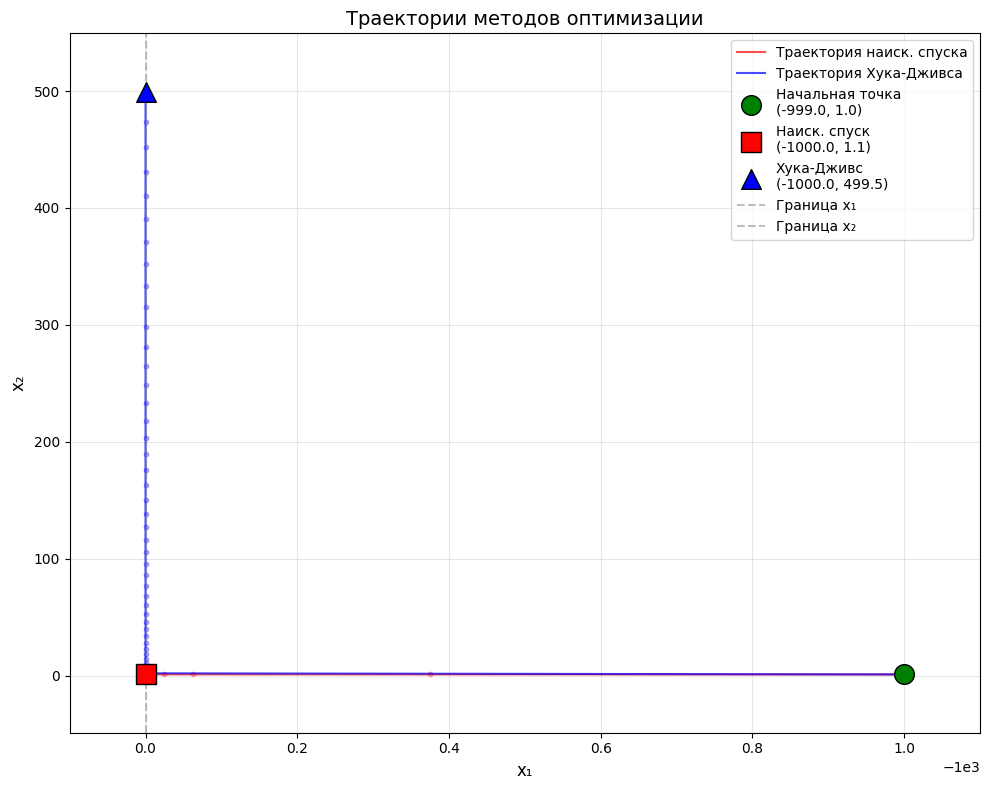


Статистика траекторий:
Метод наискорейшего спуска: 9 точек траектории
Метод Хука-Дживса: 50 точек траектории
Начальная точка: (-999.00, 1.00)
Конечная точка наиск. спуска: (-1000.00, 1.10)
Конечная точка Хука-Дживса: (-1000.00, 499.50)


In [301]:
# Cell 9: График 1 - Траектории методов
print("\n" + "="*80)
print("Траектории методов оптимизации")
print("="*80)

# Получаем результаты оптимизации
sd_x1, sd_x2 = result_sd['x_min']
hj_x1, hj_x2 = result_hj['x_min']
sd_f = result_sd['f_value']
hj_f = result_hj['f_value']

fig1, ax1 = plt.subplots(figsize=(10, 8))

# Траектория метода наискорейшего спуска (ВСЯ траектория)
if len(result_sd['trajectory']) > 0:
    traj_sd = result_sd['trajectory']
    # Рисуем всю траекторию
    ax1.plot(traj_sd[:, 0], traj_sd[:, 1], 'r-', linewidth=1.5, alpha=0.7, label='Траектория наиск. спуска')
    # Точки траектории (небольшие, чтобы не мешать)
    ax1.scatter(traj_sd[:, 0], traj_sd[:, 1], color='red', s=10, alpha=0.3)

# Траектория метода Хука-Дживса (ВСЯ траектория)
if len(result_hj['trajectory']) > 0:
    traj_hj = result_hj['trajectory']
    # Рисуем всю траекторию
    ax1.plot(traj_hj[:, 0], traj_hj[:, 1], 'b-', linewidth=1.5, alpha=0.7, label='Траектория Хука-Дживса')
    # Точки траектории (небольшие, чтобы не мешать)
    ax1.scatter(traj_hj[:, 0], traj_hj[:, 1], color='blue', s=10, alpha=0.3)

# Начальная точка (крупная и заметная)
ax1.scatter(x0[0], x0[1], color='green', s=200, label=f'Начальная точка\n({x0[0]:.1f}, {x0[1]:.1f})', 
            edgecolors='black', zorder=5, marker='o')

# Конечные точки (крупные и заметные)
ax1.scatter(sd_x1, sd_x2, color='red', s=200, label=f'Наиск. спуск\n({sd_x1:.1f}, {sd_x2:.1f})', 
            edgecolors='black', zorder=5, marker='s')
ax1.scatter(hj_x1, hj_x2, color='blue', s=200, label=f'Хука-Дживс\n({hj_x1:.1f}, {hj_x2:.1f})', 
            edgecolors='black', zorder=5, marker='^')

# Область ограничений (показываем границы)
ax1.axvline(x=SEARCH_BOUNDS['x1_min'], color='gray', linestyle='--', alpha=0.5, label='Граница x₁')
ax1.axvline(x=SEARCH_BOUNDS['x1_max'], color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=SEARCH_BOUNDS['x2_min'], color='gray', linestyle='--', alpha=0.5, label='Граница x₂')
ax1.axhline(y=SEARCH_BOUNDS['x2_max'], color='gray', linestyle='--', alpha=0.5)

# Настройки графика
ax1.set_xlabel('x₁', fontsize=12)
ax1.set_ylabel('x₂', fontsize=12)
ax1.set_title('Траектории методов оптимизации', fontsize=14)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Определяем границы графика на основе всей траектории
all_x = []
all_y = []

# Добавляем точки из траекторий
if len(result_sd['trajectory']) > 0:
    all_x.extend(result_sd['trajectory'][:, 0])
    all_y.extend(result_sd['trajectory'][:, 1])

if len(result_hj['trajectory']) > 0:
    all_x.extend(result_hj['trajectory'][:, 0])
    all_y.extend(result_hj['trajectory'][:, 1])

# Добавляем начальную и конечные точки
all_x.extend([x0[0], sd_x1, hj_x1])
all_y.extend([x0[1], sd_x2, hj_x2])

# Устанавливаем границы с небольшим запасом
if all_x and all_y:
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    
    # Добавляем 10% запаса по краям
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    ax1.set_xlim(x_min - 0.1*x_range, x_max + 0.1*x_range)
    ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

# Альтернативно: фиксированные границы для лучшего обзора
# ax1.set_xlim(-6000, 100)  # Основная область движения влево
# ax1.set_ylim(-100, 3000)  # Основная область движения вверх

plt.tight_layout()
plt.show()

# Выводим статистику по траекториям
print(f"\nСтатистика траекторий:")
print(f"Метод наискорейшего спуска: {len(result_sd['trajectory'])} точек траектории")
print(f"Метод Хука-Дживса: {len(result_hj['trajectory'])} точек траектории")
print(f"Начальная точка: ({x0[0]:.2f}, {x0[1]:.2f})")
print(f"Конечная точка наиск. спуска: ({sd_x1:.2f}, {sd_x2:.2f})")
print(f"Конечная точка Хука-Дживса: ({hj_x1:.2f}, {hj_x2:.2f})")


Траектории переменных x₁ и x₂


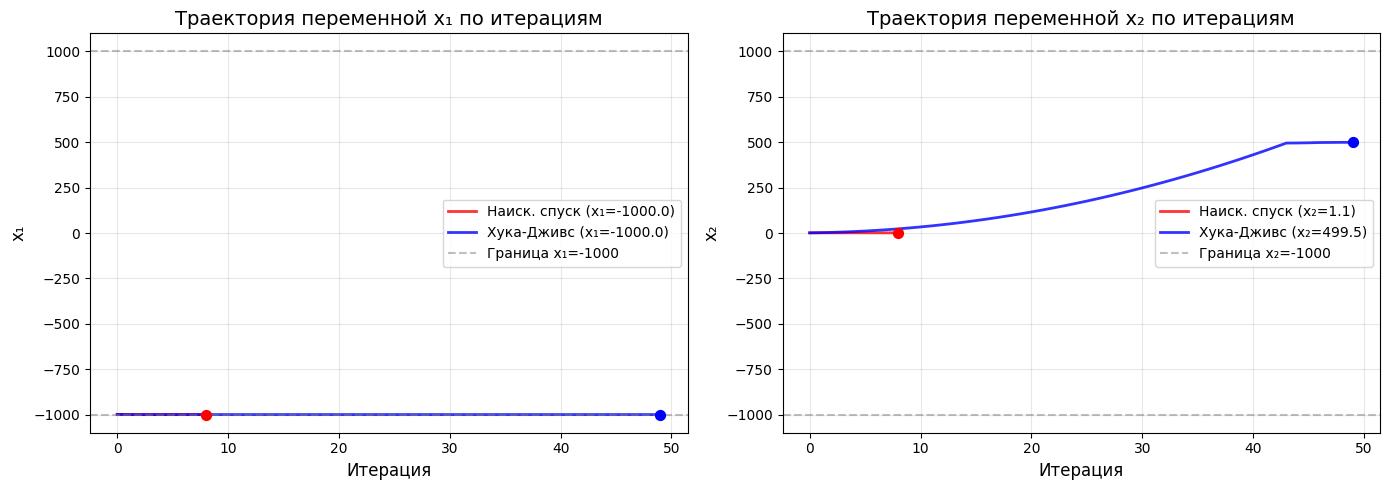


Анализ траекторий переменных:

Переменная x₁:
  Начальное значение: -999.00
  Метод наиск. спуска: -1000.00 (изменение: -1.00)
  Метод Хука-Дживса: -1000.00 (изменение: -1.00)

Переменная x₂:
  Начальное значение: 1.00
  Метод наиск. спуска: 1.10 (изменение: 0.10)
  Метод Хука-Дживса: 499.50 (изменение: 498.50)

Основные направления движения:
  x₁: уменьшается к нижней границе (-1000)
  x₂: увеличивается от начального значения


In [302]:
# Cell 10: График 2 - Траектории переменных x1 и x2
print("\n" + "="*80)
print("Траектории переменных x₁ и x₂")
print("="*80)

fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 5))

# 2.1. Траектория переменной x₁ по итерациям
# Метод наискорейшего спуска
if len(result_sd['trajectory']) > 0:
    x1_values_sd = result_sd['trajectory'][:, 0]
    iterations_sd = range(len(x1_values_sd))
    ax2.plot(iterations_sd, x1_values_sd, 'r-', linewidth=2, 
             label=f'Наиск. спуск (x₁={sd_x1:.1f})', alpha=0.8)
    
    # Отмечаем конечную точку
    ax2.scatter(len(x1_values_sd)-1, sd_x1, color='red', s=50, zorder=5)

# Метод Хука-Дживса
if len(result_hj['trajectory']) > 0:
    x1_values_hj = result_hj['trajectory'][:, 0]
    iterations_hj = range(len(x1_values_hj))
    ax2.plot(iterations_hj, x1_values_hj, 'b-', linewidth=2, 
             label=f'Хука-Дживс (x₁={hj_x1:.1f})', alpha=0.8)
    
    # Отмечаем конечную точку
    ax2.scatter(len(x1_values_hj)-1, hj_x1, color='blue', s=50, zorder=5)

# Горизонтальная линия для границы x₁
ax2.axhline(y=SEARCH_BOUNDS['x1_min'], color='gray', linestyle='--', alpha=0.5, 
            label=f'Граница x₁={SEARCH_BOUNDS["x1_min"]}')
ax2.axhline(y=SEARCH_BOUNDS['x1_max'], color='gray', linestyle='--', alpha=0.5)

ax2.set_xlabel('Итерация', fontsize=12)
ax2.set_ylabel('x₁', fontsize=12)
ax2.set_title('Траектория переменной x₁ по итерациям', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 2.2. Траектория переменной x₂ по итерациям
# Метод наискорейшего спуска
if len(result_sd['trajectory']) > 0:
    x2_values_sd = result_sd['trajectory'][:, 1]
    ax3.plot(iterations_sd, x2_values_sd, 'r-', linewidth=2, 
             label=f'Наиск. спуск (x₂={sd_x2:.1f})', alpha=0.8)
    
    # Отмечаем конечную точку
    ax3.scatter(len(x2_values_sd)-1, sd_x2, color='red', s=50, zorder=5)

# Метод Хука-Дживса
if len(result_hj['trajectory']) > 0:
    x2_values_hj = result_hj['trajectory'][:, 1]
    ax3.plot(iterations_hj, x2_values_hj, 'b-', linewidth=2, 
             label=f'Хука-Дживс (x₂={hj_x2:.1f})', alpha=0.8)
    
    # Отмечаем конечную точку
    ax3.scatter(len(x2_values_hj)-1, hj_x2, color='blue', s=50, zorder=5)

# Горизонтальные линии для границ x₂
ax3.axhline(y=SEARCH_BOUNDS['x2_min'], color='gray', linestyle='--', alpha=0.5, 
            label=f'Граница x₂={SEARCH_BOUNDS["x2_min"]}')
ax3.axhline(y=SEARCH_BOUNDS['x2_max'], color='gray', linestyle='--', alpha=0.5)

ax3.set_xlabel('Итерация', fontsize=12)
ax3.set_ylabel('x₂', fontsize=12)
ax3.set_title('Траектория переменной x₂ по итерациям', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим дополнительную информацию о траекториях переменных
print(f"\nАнализ траекторий переменных:")
print(f"\nПеременная x₁:")
print(f"  Начальное значение: {x0[0]:.2f}")
print(f"  Метод наиск. спуска: {sd_x1:.2f} (изменение: {sd_x1 - x0[0]:.2f})")
print(f"  Метод Хука-Дживса: {hj_x1:.2f} (изменение: {hj_x1 - x0[0]:.2f})")

print(f"\nПеременная x₂:")
print(f"  Начальное значение: {x0[1]:.2f}")
print(f"  Метод наиск. спуска: {sd_x2:.2f} (изменение: {sd_x2 - x0[1]:.2f})")
print(f"  Метод Хука-Дживса: {hj_x2:.2f} (изменение: {hj_x2 - x0[1]:.2f})")

print(f"\nОсновные направления движения:")
print(f"  x₁: уменьшается к нижней границе ({SEARCH_BOUNDS['x1_min']})")
print(f"  x₂: увеличивается от начального значения")


3D график


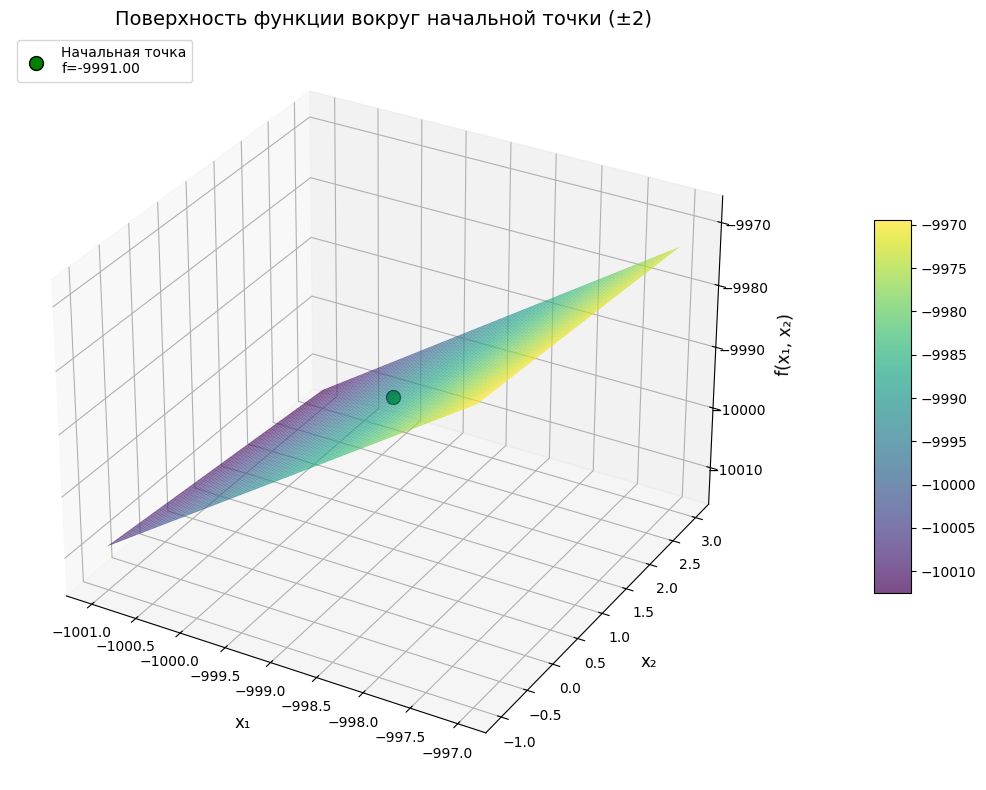

In [303]:
# Cell 12: График 4 - Упрощенный 3D график поверхности
print("\n" + "="*80)
print("3D график")
print("="*80)

# Создаем упрощенную поверхность вокруг начальной точки
range_size_simple = 2  # Маленький диапазон для наглядности
x1_simple = np.linspace(x0[0] - range_size_simple, x0[0] + range_size_simple, 50)
x2_simple = np.linspace(x0[1] - range_size_simple, x0[1] + range_size_simple, 50)
X1_simple, X2_simple = np.meshgrid(x1_simple, x2_simple)

# Вычисляем значения функции (с защитой от переполнения)
Z_simple = np.zeros_like(X1_simple)
for i in range(X1_simple.shape[0]):
    for j in range(X1_simple.shape[1]):
        # Вычисляем без использования exp для больших значений
        arg = X1_simple[i, j] + 2 * X2_simple[i, j]
        if arg > 10:  # Ограничиваем аргумент экспоненты
            Z_simple[i, j] = 10 * X1_simple[i, j] - X2_simple[i, j] + np.exp(10)
        else:
            Z_simple[i, j] = 10 * X1_simple[i, j] - X2_simple[i, j] + np.exp(arg)

fig4 = plt.figure(figsize=(12, 8))
ax5 = fig4.add_subplot(111, projection='3d')

# Строим поверхность
surf = ax5.plot_surface(X1_simple, X2_simple, Z_simple, 
                        cmap='viridis', alpha=0.7, linewidth=0.1, antialiased=True)

# Отмечаем начальную точку
ax5.scatter(x0[0], x0[1], f(x0), color='green', s=100, 
            label=f'Начальная точка\nf={f(x0):.2f}', edgecolors='black')

ax5.set_xlabel('x₁', fontsize=12, labelpad=10)
ax5.set_ylabel('x₂', fontsize=12, labelpad=10)
ax5.set_zlabel('f(x₁, x₂)', fontsize=12, labelpad=10)
ax5.set_title(f'Поверхность функции вокруг начальной точки (±{range_size_simple})', fontsize=14)
ax5.legend(loc='upper left', fontsize=10)

# Добавляем цветовую шкалу
fig4.colorbar(surf, ax=ax5, shrink=0.5, aspect=10, pad=0.1)

plt.tight_layout()
plt.show()

In [304]:
# Сводная таблица результатов
print("\n" + "="*80)
print("Результаты")
print("="*80)

print(f"{'Параметр':<25} {'Наиск. спуск':<20} {'Хука-Дживс':<20} {'Разница':<15}")
print("-"*80)

print(f"{'Конечная точка x₁':<25} {sd_x1:<20.2f} {hj_x1:<20.2f} {abs(sd_x1 - hj_x1):<15.2f}")
print(f"{'Конечная точка x₂':<25} {sd_x2:<20.2f} {hj_x2:<20.2f} {abs(sd_x2 - hj_x2):<15.2f}")
print(f"{'Значение f(x)':<25} {sd_f:<20.2f} {hj_f:<20.2f} {abs(sd_f - hj_f):<15.2f}")
print(f"{'Итераций':<25} {result_sd['iterations']:<20} {result_hj['iterations']:<20} {abs(result_sd['iterations'] - result_hj['iterations']):<15}")
print(f"{'Вычислений f(x)':<25} {result_sd['f_calls']:<20} {result_hj['f_calls']:<20} {abs(result_sd['f_calls'] - result_hj['f_calls']):<15}")
print(f"{'Вычислений ∇f(x)':<25} {result_sd['grad_calls']:<20} {result_hj['grad_calls']:<20} {abs(result_sd['grad_calls'] - result_hj['grad_calls']):<15}")
print(f"{'Всего вычислений':<25} {result_sd['f_calls'] + result_sd['grad_calls']:<20} {result_hj['f_calls'] + result_hj['grad_calls']:<20} "
      f"{abs((result_sd['f_calls'] + result_sd['grad_calls']) - (result_hj['f_calls'] + result_hj['grad_calls'])):<15}")

print("-"*80)
distance_to_boundary_sd = abs(sd_x1 - SEARCH_BOUNDS['x1_min'])
distance_to_boundary_hj = abs(hj_x1 - SEARCH_BOUNDS['x1_min'])

print(f"{'Расстояние до границы x₁':<25} {distance_to_boundary_sd:<20.2f} {distance_to_boundary_hj:<20.2f} "
      f"{abs(distance_to_boundary_sd - distance_to_boundary_hj):<15.2f}")



print("="*80)


Результаты
Параметр                  Наиск. спуск         Хука-Дживс           Разница        
--------------------------------------------------------------------------------
Конечная точка x₁         -1000.00             -1000.00             0.00           
Конечная точка x₂         1.10                 499.50               498.40         
Значение f(x)             -10001.10            -10499.13            498.03         
Итераций                  8                    49                   41             
Вычислений f(x)           124                  343                  219            
Вычислений ∇f(x)          8                    0                    8              
Всего вычислений          132                  343                  211            
--------------------------------------------------------------------------------
Расстояние до границы x₁  0.00                 0.00                 0.00           
